# Evaluation on MIMIC-CXR manual annotation

We have 100 maunally annotated documents as ground-truth/testset, of which 64 docs have coref while the others are 0-coref.

The individual ground-truth conll files are saved in "/individual_conll_ground_truth".

To evaluate, 

In [32]:
import sys
sys.path.append("../../src")
sys.path.append("../../../../git_clone_repos/fast-coref/src")

import os
import ast
from collections import Counter
import re

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, HTML
from common_utils.coref_utils import ConllToken
# display(HTML(df.to_html()))

from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Event
from common_utils.data_loader_utils import load_mimic_cxr_bySection
from common_utils.coref_utils import resolve_mention_and_group_num
from common_utils.file_checker import FileChecker
from common_utils.common_utils import check_and_create_dirs, check_and_remove_dirs, check_and_remove_file
from coreference_resolution.data_preprocessing.mimic_cxr_csv2conll import copy_and_paste_conll
from statistic.coref_socring import invoke_conll_script, resolve_conll_script_output

FILE_CHECKER = FileChecker()
START_EVENT = Event()

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [33]:
def compute_conll_score(conll_file_gt, conll_file_pred):
    print("gt:", conll_file_gt)
    print("pred:", conll_file_pred)
    scorer_path = "./wrong_conll_scorer_example/reference-coreference-scorers/scorer.pl"
    overall_f1 = []
    for metric in ['muc', 'bcub', 'ceafe']:
        out, err = invoke_conll_script(scorer_path, metric, conll_file_gt, conll_file_pred)
        mention_recall, mention_precision, mention_f1, coref_recall, coref_precision, coref_f1 = resolve_conll_script_output(out)
        overall_f1.append(coref_f1)
        print(f"Metric: {metric}")
        print(f"mention_recall, mention_precision, mention_f1: {mention_recall}, {mention_precision}, {mention_f1}")
        print(f"coref_recall, coref_precision, coref_f1: {coref_recall}, {coref_precision}, {coref_f1}")

    print(f"Overall F1: {sum(overall_f1) / len(overall_f1)}")

In [34]:
def from_csv_to_conll(section_name, doc_id, output_file_path, input_file_path_or_df, coref_group_conll_colName, sentence_group_colName,token_colName):
    BEGIN = f"#begin document ({doc_id}_{section_name}); part 0\n"
    SENTENCE_SEPARATOR = "\n"
    END = "#end document\n"

    # Resolve CSV file
    sentenc_list: list[list[ConllToken]] = []
    if isinstance(input_file_path_or_df, str):
        df = pd.read_csv(input_file_path_or_df, index_col=0, na_filter=False)
    else:
        df = input_file_path_or_df

    sentence_id = 0
    while True:
        token_list: list[ConllToken] = []
        df_sentence = df[df.loc[:, sentence_group_colName] == sentence_id].reset_index()
        if df_sentence.empty:
            break
        for _idx, data in df_sentence.iterrows():
            # Skip all whitespces like "\n", "\n " and " ".
            if str(data[token_colName]).strip() == "":
                continue
            conllToken = ConllToken(doc_id+"_"+section_name, sentence_id, _idx, data[token_colName])
            coref_col_cell = data[coref_group_conll_colName]
            if isinstance(coref_col_cell, str) and coref_col_cell != "-1":
                conllToken.add_coref_label("|".join(ast.literal_eval(coref_col_cell)))
            token_list.append(conllToken)
        sentenc_list.append(token_list)
        sentence_id += 1

    with open(output_file_path, "a", encoding="UTF-8") as out:
        out.write(BEGIN)
        for sent in sentenc_list:
            # Skip empty sentence
            if len(sent) == 1 and sent[0].tokenStr == "":
                continue
            for tok in sent:
                out.write(tok.get_conll_str() + "\n")
            out.write(SENTENCE_SEPARATOR)
        out.write(END)
        out.write("\n")

In [35]:
def from_list_to_conll(output_file_path, doc_id, section_name, old_sentenc_list):
    BEGIN = f"#begin document ({doc_id}_{section_name}); part 0\n"
    SENTENCE_SEPARATOR = "\n"
    END = "#end document\n"

    sentenc_list: list[list[ConllToken]] = []
    for sentence_id, old_token_list in enumerate(old_sentenc_list):
        token_list: list[ConllToken] = []
        for tok_idx, tok in enumerate(old_token_list):
            # Skip all whitespces like "\n", "\n " and " ".
            if tok.tokenStr.strip() == "":
                continue
            conllToken = ConllToken(doc_id+"_"+section_name, sentence_id, tok_idx, tok.tokenStr)
            conllToken.corefLabel = tok.corefLabel
            token_list.append(conllToken)
        sentenc_list.append(token_list)

    with open(output_file_path, "a", encoding="UTF-8") as out:
        out.write(BEGIN)
        for sent in sentenc_list:
            # Skip empty sentence
            if len(sent) == 1 and sent[0].tokenStr == "":
                continue
            for tok in sent:
                out.write(tok.get_conll_str() + "\n")
            out.write(SENTENCE_SEPARATOR)
        out.write(END)
        out.write("\n")

In [36]:
def remove_singleton(df_pred, coref_group_conll_colName):
    # remove singleton from df_pred
    corefGroup_counter = Counter()
    for conll_corefGroup_list_str in df_pred[~df_pred.loc[:, coref_group_conll_colName].isin(["-1", -1.0, np.nan])].loc[:, coref_group_conll_colName].to_list():
        for conll_corefGroup_str in ast.literal_eval(conll_corefGroup_list_str):
            result = re.search(r"(\d+)\)", conll_corefGroup_str)  # An coref mention always end with "number)"
            if result:
                corefGroup_counter.update([int(result.group(1))])

    non_singletone_counter: list[tuple] = list(filter(lambda item: item[1] > 1, corefGroup_counter.items()))
    coref_group_list_notSingleton = [int(k) for k, v in non_singletone_counter]
    
    # iter df rows, keep only the non_singleton coref id, and remove the others.
    for idx, item in df_pred.iterrows():
        conll_corefGroup_list_str = item.get(coref_group_conll_colName)
        new_conll_corefGroup_str_list = []
        # Remove singleton id
        if conll_corefGroup_list_str in ["-1", -1.0, np.nan]:
            continue
        for conll_corefGroup_str in ast.literal_eval(conll_corefGroup_list_str):
            res = re.match(r"\(?(\d+)\)?",conll_corefGroup_str)
            coref_group_id = int(res.groups()[0])
            if coref_group_id in coref_group_list_notSingleton:
                new_conll_corefGroup_str_list.append(conll_corefGroup_str)
        df_pred.loc[idx,coref_group_conll_colName] = str(new_conll_corefGroup_str_list) if new_conll_corefGroup_str_list else -1
    
    return df_pred

In [37]:
output_dir = "../../resources/eval"

A list of gt docs

In [38]:
gt_dict_allDoc:dict[str,list] = {}
for section_name in ["findings","impression"]:
    gt_all_dir = os.path.join("../../output/mimic_cxr/ground_truth", section_name)
    gt_dict_allDoc[section_name] = [i.rstrip(".csv") for i in FILE_CHECKER.filter(os.listdir(gt_all_dir))]

A list of gt docs that has coref

In [39]:
gt_dict_hasCoref:dict[str,list] = {}
for section_name in ["findings","impression"]:
    gt_all_dir = os.path.join("../../output/mimic_cxr/coref/individual_conll_ground_truth", section_name)
    gt_dict_hasCoref[section_name] = [i.rstrip(".conll") for i in FILE_CHECKER.filter(os.listdir(gt_all_dir))]

general gt conll file

In [9]:
output_conll_file_gt = os.path.join(output_dir, "gt_100_noWhich.conll")
check_and_remove_file(output_conll_file_gt)
for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in doc_list:
        input_conll_file = os.path.join("../../output/mimic_cxr/coref/individual_conll_ground_truth", section_name, f"{doc_id}.conll")
        if os.path.exists(input_conll_file):
            copy_and_paste_conll(input_conll_file, output_conll_file_gt)
        else:
            input_csv_file = os.path.join("../../output/mimic_cxr/ground_truth", section_name, f"{doc_id}.csv")
            from_csv_to_conll(section_name, doc_id, output_conll_file_gt, input_csv_file, "[gt]coref_group_conll", "[sp]sentence_group","[sp]token")

## Experiment 1-1: ensemble (majority voting)

### 1-1-1: Binary Eval (has coref / no coref)

A list of predict docs that has coref

In [120]:
pred_dict_hasCoref: dict[str, list[str]] = {}
for section_name in ["findings","impression"]:
    ensemble_dir = os.path.join("../../output/mimic_cxr/coref/individual_conll", section_name)
    pred_dict_hasCoref[section_name] = [i.rstrip(".conll") for i in FILE_CHECKER.filter(os.listdir(ensemble_dir))]

In [121]:
true_positive = {}
false_positive = {} # predict true, actual false
false_negative = {} # predict false, actual true
true_negative = {}
for section_name in ["findings","impression"]:
    pred_hasCoref = set(pred_dict_hasCoref[section_name])
    gt_hasCoref = set(gt_dict_hasCoref[section_name])
    gt_all = set(gt_dict_allDoc[section_name])

    true_positive[section_name] = pred_hasCoref.intersection(gt_hasCoref)
    false_positive[section_name] = gt_all.intersection(pred_hasCoref) - gt_hasCoref
    false_negative[section_name] = gt_hasCoref - pred_hasCoref
    true_negative[section_name] = gt_all - pred_hasCoref

In [122]:
for section_name in ["findings","impression"]:
    print(section_name)
    print("true_positive",len(true_positive[section_name]))
    print("false_positive",len(false_positive[section_name]))
    print("false_negative",len(false_negative[section_name]))
    print("true_negative",len(true_negative[section_name]))

findings
true_positive 21
false_positive 1
false_negative 10
true_negative 28
impression
true_positive 21
false_positive 1
false_negative 12
true_negative 28


'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

'binary':
Only report results for the class specified by pos_label

In [123]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

y_true = ["has_coref" if doc_id in gt_dict_hasCoref[section_name] else "no_coref" for section_name, doc_list in gt_dict_allDoc.items() for doc_id in doc_list]
y_pred = ["has_coref" if doc_id in pred_dict_hasCoref[section_name] else "no_coref" for section_name, doc_list in gt_dict_allDoc.items() for doc_id in doc_list]
confusion_arr = confusion_matrix(y_true, y_pred, labels=["has_coref","no_coref"])
# TP FN
# FP TN
print(confusion_arr)
print()

micro_precision_recall_f1 = precision_recall_fscore_support(y_true, y_pred, average='micro')
macro_precision_recall_f1 = precision_recall_fscore_support(y_true, y_pred, average='macro')
weigthed_precision_recall_f1 = precision_recall_fscore_support(y_true, y_pred, average='weighted')
binary_precision_recall_f1 = precision_recall_fscore_support(y_true, y_pred, average=None, labels=["has_coref","no_coref"])
precision,recall,f1,support = binary_precision_recall_f1

print("precision, recall, f1, support(class_ele_num):")
print("micro:", micro_precision_recall_f1)
print("macro:", macro_precision_recall_f1)
print("weigthed macro:", weigthed_precision_recall_f1)
for i,j in zip(["has_coref","no_coref"],np.matrix([precision,recall,f1,support]).getT()):
    print("binary",i,j)

[[42 22]
 [ 2 34]]

precision, recall, f1, support(class_ele_num):
micro: (0.76, 0.76, 0.76, None)
macro: (0.7808441558441559, 0.8003472222222222, 0.7584541062801933, None)
weigthed macro: (0.8294805194805196, 0.76, 0.763864734299517, None)
binary has_coref [[ 0.95454545  0.65625     0.77777778 64.        ]]
binary no_coref [[ 0.60714286  0.94444444  0.73913043 36.        ]]


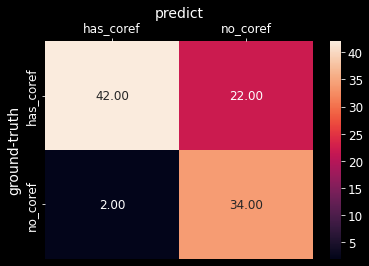

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure() #this creates a new figure on which your plot will appear
plt.tight_layout()

ax = sns.heatmap(confusion_arr, xticklabels=["has_coref", "no_coref"], yticklabels=["has_coref", "no_coref"], annot=True, fmt='.2f')

ax.set_xlabel('predict')
ax.set_ylabel('ground-truth')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

### 1-1-2: CoNLL F1 Score

#### Only TP (42 doc)

In [ ]:
output_conll_file_gt = os.path.join(output_dir, "gt_42_noWhich.conll")
output_conll_file_pred = os.path.join(output_dir, "pred_42.conll")
check_and_remove_file(output_conll_file_gt)
check_and_remove_file(output_conll_file_pred)
for section_name in ["findings","impression"]:
    for doc_id in true_positive[section_name]:
        # gt
        input_conll_file = os.path.join("../../output/mimic_cxr/coref/individual_conll_ground_truth", section_name, f"{doc_id}.conll")
        copy_and_paste_conll(input_conll_file, output_conll_file_gt)
        # pred
        input_conll_file = os.path.join("../../output/mimic_cxr/coref/individual_conll", section_name, f"{doc_id}.conll")
        copy_and_paste_conll(input_conll_file, output_conll_file_pred)

In [ ]:
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

#### TP + FP (42+2), which is the ensemble application scenario

gt_44 (tp) + pred_44 (tp+fp)

In [ ]:
output_conll_file_gt = os.path.join(output_dir, "gt_44_noWhich.conll")
check_and_remove_file(output_conll_file_gt)
for section_name in ["findings","impression"]:
    doc_list = list(true_positive[section_name]) # false_positive files are not existing here, thus ignore
    for doc_id in doc_list:
        input_conll_file = os.path.join("../../output/mimic_cxr/coref/individual_conll_ground_truth", section_name, f"{doc_id}.conll")
        copy_and_paste_conll(input_conll_file, output_conll_file_gt)

output_conll_file_pred = os.path.join(output_dir, "pred_44.conll")
check_and_remove_file(output_conll_file_pred)
for section_name in ["findings","impression"]:
    doc_list = list(true_positive[section_name]) + list(false_positive[section_name])
    for doc_id in doc_list:
        input_conll_file = os.path.join("../../output/mimic_cxr/coref/individual_conll", section_name, f"{doc_id}.conll")
        copy_and_paste_conll(input_conll_file, output_conll_file_pred)

In [ ]:
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

#### All (100), which is the actural conll scoring scenario.

gt_100 + pred_100

##### Experiment 100x: Need to generate majority_voting gt files when only have fast_coref_onto_i2b2 outputs

modify /config/coreference_resolution/coref_voting/mimic_cxr.yaml

In [31]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d %H:%M:%S")

now = 2022-11-03 00:21:03.794004
date and time = 2022-11-03 00:21:03


In [20]:
from common_utils.coref_utils import shuffle_list
import coref_voting
from coref_voting import DocClass, MentionClass, compute_voting_result, get_output_df
from hydra import compose, initialize
from omegaconf import OmegaConf
from nlp_ensemble.nlp_menbers import play_fastcoref

mv_output_base_dir = os.path.join("../../output/mimic_cxr/coref_voting/majority_voting_eval100x")

config = None
with initialize(version_base=None, config_path="../config", job_name="create_ann"):
        config = compose(config_name="coreference_resolution", overrides=["+coreference_resolution/coref_voting@_global_=mimic_cxr"])

def batch_processing3(config, spacy_file_path, section_name, file_name):
    """ Voting on one document """

    START_EVENT.wait()

    # Read spacy output as alignment base
    df_spacy = pd.read_csv(spacy_file_path, index_col=0, na_filter=False)
    # Some of the i2b2 raw files are utf-8 start with DOM, but we didn't remove the DOM character, thus we fix it here.
    df_spacy.iloc[0] = df_spacy.iloc[0].apply(lambda x: x.replace("\ufeff", "").replace("\xef\xbb\xbf", "") if isinstance(x, str) else x)

    docObj: DocClass = coref_voting.resolve_voting_info(config, df_spacy, section_name, file_name)
    valid_mention_group: list[set[MentionClass]] = compute_voting_result(config, docObj)
    df_out = get_output_df(config, df_spacy, valid_mention_group, docObj)

    output_dir = os.path.join(mv_output_base_dir, section_name)
    check_and_create_dirs(output_dir)
    output_file_path = os.path.join(output_dir, file_name)

    df_out.to_csv(output_file_path)

    return f"{file_name} done."

for section_name in ["findings","impression"]:
    # sample_num_str = "{1: 544, 2: 544, 3: 295, 4: 83, 5: 25, 6: 6, 7: 2, 8: 1}"
    with ProcessPoolExecutor(max_workers=config.thread.workers) as executor:
        all_task = []
        doc_list = gt_dict_allDoc[section_name]
        for doc_id in doc_list:
            file_name = doc_id + ".csv"
            spacy_out_dir = os.path.join(config.input.source.baseline_model.dir, section_name)
            spacy_file_path = os.path.join(spacy_out_dir, file_name)
            all_task.append(executor.submit(batch_processing3, config, spacy_file_path, section_name, file_name))
        
         # Notify tasks to start
        START_EVENT.set()

        if all_task:
            for future in tqdm(as_completed(all_task), total=len(all_task)):
                msg = future.result()

        executor.shutdown(wait=True, cancel_futures=False)
        START_EVENT.clear()

100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


##### Have majority_voting gt files already

In [21]:
output_conll_file_pred = os.path.join(output_dir, "pred_mv.conll")
check_and_remove_file(output_conll_file_pred)
for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in doc_list:
        input_csv_file = os.path.join(mv_output_base_dir, section_name, f"{doc_id}.csv")
        from_csv_to_conll(section_name, doc_id, output_conll_file_pred, input_csv_file, "[mv]coref_group_conll", "[sp]sentence_group","[sp]token")

output_conll_file_gt = os.path.join(output_dir, "gt_100_noWhich.conll")
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

gt: ../../resources/eval/gt_100_noWhich.conll
pred: ../../resources/eval/pred_mv.conll
Metric: muc
mention_recall, mention_precision, mention_f1: 56.77, 75.17, 64.68
coref_recall, coref_precision, coref_f1: 50.47, 67.94, 57.92
Metric: bcub
mention_recall, mention_precision, mention_f1: 56.77, 75.17, 64.68
coref_recall, coref_precision, coref_f1: 52.12, 69.88, 59.71
Metric: ceafe
mention_recall, mention_precision, mention_f1: 56.77, 75.17, 64.68
coref_recall, coref_precision, coref_f1: 54.74, 71.08, 61.84
Overall F1: 59.82333333333333


## Experiment 1-2: scoref, dcoref, fast_coref_joint

In [10]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from nlp_ensemble.nlp_menbers import play_fastcoref

config = None
with initialize(version_base=None, config_path="../config", job_name="statistic"):
        config = compose(config_name="nlp_ensemble", overrides=["+statistic/coref_scoring@_global_=mimic_cxr"])

### Common way for testing scoref, dcoref, fast_coref_joint

In [ ]:
from statistic.coref_socring import align_spacy_to_ground_truth, align_to_spacy, convert_non_spacy_token_csv_to_conll_format, convert_spacy_token_csv_to_conll_format, find_cloest_index

csv_file_dir = "../../output/mimic_cxr/nlp_ensemble/corenlp/dcoref"
output_conll_file_pred = os.path.join(output_dir, "pred_dcoref.conll")
check_and_remove_file(output_conll_file_pred)

model_cfg = config.input.source.models.get("rb") # ml -> scoref, rb -> dcoref, fj -> fast_coref_joint, fj2 -> fast_coref_onto_i2b2
gt_cfg = config.input.ground_truth
scorer_cfg = config.scorer
spacy_cfg = config.input.spacy

for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in tqdm(doc_list):
        pred_file_path = os.path.join(csv_file_dir, section_name, f"{doc_id}.csv")
        df_pred = pd.read_csv(pred_file_path, index_col=0, na_filter=False)
        gt_file_path = os.path.join("../../output/mimic_cxr/ground_truth", section_name, f"{doc_id}.csv")
        df_gt = pd.read_csv(gt_file_path, index_col=0, na_filter=False)
        spacy_file_path = os.path.join("../../output/mimic_cxr/nlp_ensemble/spacy", section_name, f"{doc_id}.csv")
        df_spacy = pd.read_csv(spacy_file_path, index_col=0, na_filter=False)

        # Some of the i2b2 raw files are utf-8 start with DOM, but we didn't remove the DOM character, thus we fix it here.
        df_gt.iloc[0] = df_gt.iloc[0].apply(lambda x: x.replace("\ufeff", "").replace("\xef\xbb\xbf", "") if isinstance(x, str) else x)
        df_pred.iloc[0] = df_pred.iloc[0].apply(lambda x: x.replace("\ufeff", "").replace("\xef\xbb\xbf", "") if isinstance(x, str) else x)
        df_spacy.iloc[0] = df_spacy.iloc[0].apply(lambda x: x.replace("\ufeff", "").replace("\xef\xbb\xbf", "") if isinstance(x, str) else x)

        df_pred = remove_singleton(df_pred, model_cfg.target_column.coref_group_conll)

        # Generate conll format predicted files
        if model_cfg.align_to_spacy:

            # Algin to spacy first, then align spacy to gt
            model2spacy_tok_indices, coref_index_appearance_count_dict = align_to_spacy(config, model_cfg, df_spacy, df_pred)

            gt_token_list = df_gt.loc[:, gt_cfg.target_column.token_for_alignment].tolist()
            spacy_token_list = df_spacy.loc[:, spacy_cfg.target_column.token].tolist()
            spacy2gt_tok_indices, _ = align_spacy_to_ground_truth(gt_token_list, spacy_token_list)
            sentence_list_pred = convert_non_spacy_token_csv_to_conll_format(config, model_cfg, section_name, doc_id, coref_index_appearance_count_dict, model2spacy_tok_indices,
                                                                             spacy2gt_tok_indices, df_pred, df_spacy)
        else:
            # Directly align to ground-truth
            gt_token_list = df_gt.loc[:, gt_cfg.target_column.token_for_alignment].tolist()
            spacy_token_list = df_pred.loc[:, model_cfg.target_column.token].tolist()
            # Some token has conll label but does not exist in gt, that is what `empty_token_idx_with_conll_label_dict` is used for.
            spacy2gt_tok_indices, empty_token_idx_with_conll_label_dict = align_spacy_to_ground_truth(
                gt_token_list, spacy_token_list, df_spacy=df_spacy, spacy_cfg=spacy_cfg, df_pred=df_pred, model_cfg=model_cfg)
            target_token_index_and_conll_label_dict = find_cloest_index(spacy2gt_tok_indices, empty_token_idx_with_conll_label_dict)
            sentence_list_pred = convert_spacy_token_csv_to_conll_format(config, model_cfg, section_name, doc_id, spacy2gt_tok_indices, df_pred, target_token_index_and_conll_label_dict)


        # Write conll
        from_list_to_conll(output_conll_file_pred, doc_id, section_name, sentence_list_pred)

In [ ]:
output_conll_file_gt = os.path.join(output_dir, "gt_100_noWhich.conll")
# output_conll_file_pred = os.path.join(output_dir, "pred_dcoref.conll")
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

### Another way for testing fast_coref_joint

In [15]:
gt_cfg = config.input.ground_truth
scorer_cfg = config.scorer
spacy_cfg = config.input.spacy

output_conll_file_pred = os.path.join(output_dir, "pred_fj2.conll")
check_and_remove_file(output_conll_file_pred)
for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in doc_list:
        input_csv_file = os.path.join("../../output/mimic_cxr/nlp_ensemble/fast_coref_onto_i2b2", section_name, f"{doc_id}.csv")
        df_pred = pd.read_csv(input_csv_file, index_col=0, na_filter=False)
        df_pred = remove_singleton(df_pred, "[fj]coref_group_conll")
        from_csv_to_conll(section_name, doc_id, output_conll_file_pred, df_pred, "[fj]coref_group_conll", "[fj]sentence_group","[fj]token_from_spacy")

output_conll_file_gt = os.path.join(output_dir, "gt_100_noWhich.conll")
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

gt: ../../resources/eval/gt_100_noWhich.conll
pred: ../../resources/eval/pred_fj2.conll
Metric: muc
mention_recall, mention_precision, mention_f1: 59.37, 74.5, 66.08
coref_recall, coref_precision, coref_f1: 54.28, 67.05, 60.0
Metric: bcub
mention_recall, mention_precision, mention_f1: 59.37, 74.5, 66.08
coref_recall, coref_precision, coref_f1: 55.42, 68.06, 61.09
Metric: ceafe
mention_recall, mention_precision, mention_f1: 59.37, 74.5, 66.08
coref_recall, coref_precision, coref_f1: 55.8, 71.4, 62.64
Overall F1: 61.24333333333334


## Experiment 2: fine-tuned model

init

In [40]:
sys.path.append("../../../../git_clone_repos/fast-coref/src")
from hydra import compose, initialize
from omegaconf import OmegaConf
from nlp_ensemble.nlp_menbers import play_fastcoref

config = None
with initialize(version_base=None, config_path="../config", job_name="nlp_ensemble"):
        config = compose(config_name="nlp_ensemble", overrides=["+nlp_ensemble@_global_=mimic_cxr"])

Change the variable: model_dir and output_conll_file_pred with correct path.

In [41]:
# Init model
model_dir = "../../../../git_clone_repos/fast-coref/models/coref_joint_train_onto_i2b2_mimic_206"
config.fastcoref_joint.model_dir = os.path.join(model_dir,"best") if os.path.exists(os.path.join(model_dir,"best")) else model_dir
model, subword_tokenizer, max_segment_len = play_fastcoref.init_coref_model(config)

output_conll_file_gt = os.path.join(output_dir, "gt_100_noWhich.conll")
output_conll_file_pred = os.path.join(output_dir, "pred_model206.conll")
check_and_remove_file(output_conll_file_pred)

Model config %s metrics:
- MUC
- Bcub
- CEAFE
keep_singletons: false
seed: 45
train: true
use_wandb: false
override_encoder: true
override_memory: false
copy_from_pretrained_model: false
continue_training: false
paths:
  resource_dir: ${infra.project_dir}/coref_resources
  base_data_dir: ${paths.resource_dir}/data
  conll_scorer: ${paths.resource_dir}/reference-coreference-scorers/scorer.pl
  base_model_dir: ${infra.project_dir}/models
  model_dir: /scratch/c.c21051562/workspace/fast-coref/models/coref_joint_train_onto_i2b2_mimic_206
  best_model_dir: /scratch/c.c21051562/workspace/fast-coref/models/coref_joint_train_onto_i2b2_mimic_206/best
  model_filename: model.pth
  model_name: joint_train_onto_i2b2_mimic_206
  model_name_prefix: coref_
  model_path: /scratch/c.c21051562/workspace/fast-coref/models/coref_joint_train_onto_i2b2_mimic_206/model.pth
  best_model_path: /scratch/c.c21051562/workspace/fast-coref/models/coref_joint_train_onto_i2b2_mimic_206/best/model.pth
  doc_encoder_di

In [42]:
print("Using: ",config.fastcoref_joint.model_dir)

Using:  ../../../../git_clone_repos/fast-coref/models/coref_joint_train_onto_i2b2_mimic_206/best


predict

In [43]:
from inference.tokenize_doc import tokenize_and_segment_doc
from nlp_ensemble.nlp_menbers.play_fastcoref import inference, resolve_output
from common_utils.nlp_utils import align_byIndex_individually_nestedgruop, align_coref_groups_in_conll_format

spacy_nametyle = config.name_style.spacy.column_name
fastcoref_joint_nametyle = config.name_style.fastcoref_joint.column_name

# output_conll_file_pred = os.path.join(output_dir, "pred_joint_best.conll")
# check_and_remove_file(output_conll_file_pred)

for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in tqdm(doc_list):
        spacy_csv_file = os.path.join("../../output/mimic_cxr/nlp_ensemble/spacy", section_name, f"{doc_id}.csv")
        # Load preprocessed tokens from csv files.
        df_base = pd.read_csv(spacy_csv_file, index_col=0)
        tok_list = df_base.loc[:, spacy_nametyle.token].to_list()
        sentGroup_list = df_base.loc[:, spacy_nametyle.sentence_group].to_list()
        sent_tok_2d_list: list[list[str]] = []
        for tok, sent_id in zip(tok_list, sentGroup_list):
            tok = str(tok)  # In i2b2, some of the tokens might incorrectly be recognized as float type.
            if len(sent_tok_2d_list) == sent_id:
                sent_tok_2d_list.append([tok])
            else:
                sent_tok_2d_list[sent_id].append(tok)

        # Using longformer tokenizer to generate subtokens and form the input data.
        tokenized_doc = tokenize_and_segment_doc(sent_tok_2d_list, subword_tokenizer, max_segment_len=max_segment_len)

        # Get model output
        pred_mentions, pred_actions = inference(model, tokenized_doc)

        # Resolve model output
        coref_group_list = resolve_output(tokenized_doc, pred_mentions, pred_actions, ignore_singleton = True)

        # To dataframe
        df_fastcoref_joint = pd.DataFrame(
            {
                fastcoref_joint_nametyle["token_from_spacy"]: [str(i) for i in tok_list],
                fastcoref_joint_nametyle["sentence_group"]: [int(i) for i in sentGroup_list],
                fastcoref_joint_nametyle["coref_group"]: [str(i) for i in align_byIndex_individually_nestedgruop(len(tok_list), coref_group_list)],
                fastcoref_joint_nametyle["coref_group_conll"]: [str(i) for i in align_coref_groups_in_conll_format(len(tok_list), coref_group_list)],
            },
        )

        # Overwrite csv
        from_csv_to_conll(section_name, doc_id, output_conll_file_pred, df_fastcoref_joint, "[fj]coref_group_conll", "[fj]sentence_group","[fj]token_from_spacy")
        

100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


eval:

If gt and pred conll files are existing, we can specify the path and run the following script directly.

In [44]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

output_conll_file_gt = os.path.join(output_dir, "gt_100_noWhich.conll")
# output_conll_file_pred = os.path.join(output_dir, "pred_model305.conll")
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

gt: ../../resources/eval/gt_100_noWhich.conll
pred: ../../resources/eval/pred_model206.conll
Metric: muc
mention_recall, mention_precision, mention_f1: 60.41, 64.8, 62.53
coref_recall, coref_precision, coref_f1: 53.33, 57.14, 55.17
Metric: bcub
mention_recall, mention_precision, mention_f1: 60.41, 64.8, 62.53
coref_recall, coref_precision, coref_f1: 55.51, 59.29, 57.34
Metric: ceafe
mention_recall, mention_precision, mention_f1: 60.41, 64.8, 62.53
coref_recall, coref_precision, coref_f1: 58.15, 62.46, 60.23
Overall F1: 57.580000000000005


## Another scorer

In [119]:
import subprocess


output_conll_file_gt = os.path.join(output_dir, "gt_100_noWhich.conll")
output_conll_file_pred = os.path.join(output_dir, "pred_model204.conll")
scorer_path = "./wrong_conll_scorer_example/coval/scorer.py"
overall_f1 = []
command = ["python", scorer_path, output_conll_file_gt, output_conll_file_pred]

result = subprocess.run(command, capture_output=True, check=True)
out = result.stdout.decode('utf-8')
err = result.stderr.decode('utf-8')
print(out)

mentions   Recall: 60.42  Precision: 66.29  F1: 63.22
muc        Recall: 54.29  Precision: 59.38  F1: 56.72
bcub       Recall: 56.03  Precision: 60.55  F1: 58.21
ceafe      Recall: 57.70  Precision: 63.54  F1: 60.48
lea        Recall: 52.60  Precision: 57.05  F1: 54.74
CoNLL score: 58.47

